# Kepler model
Algorithm starting from trajectories, trying to overcome the issue of sampling

Also, we could take a batch of initial conditions and then see if it generalizes to others... is there a
critical value of the batch to have good generalization?

## Settings

In [1]:
import numpy as np
#from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf

import sys
sys.path.append("../")
from models import *
from hamiltonians import kepler
from utils import make_train_op
from losses import make_circle_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic
from utils import plot_traj, pull_back_traj

import os

DTYPE=tf.float32
NP_DTYPE=np.float32


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
sess = tf.InteractiveSession()

In [3]:
tf.set_random_seed(0)

In [4]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [5]:
k = -1
settings = {
    'k': k,
    'hamiltonian': lambda x : kepler(x,k=k),
    'd': 3,                    # space dimension
    'num_particles': 1,        # number of particles
    'minibatch_size': 2**7,    # Mini batch size
    'num_time_samples': 2**12, 
    'num_stacks_bijectors': 4, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/kepler",
    'visualize': True,
    #
#    'train_iters': 1000,
    'starter_learning_rate': 1e-3, # for exp decay and none
    'decay_lr': "piecewise",
#     'decay_steps': 15000,  # for exp decay
#     'decay_rate': 0.5,     # for exp decay
    'boundaries': [20000, 50000], # for piecewise decay
    'values': [1e-3, 1e-4, 1e-5],  # for piecewise decay
    'min_learning_rate': 1e-5
    }

## Eqs of motion - training data

Get data by sampling trajectories

In [6]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=settings['num_time_samples'])

In [7]:
# sh = (settings['d'], settings['num_particles'], 2)
# flattened_sh = (settings['d']*settings['num_particles']*2,)
# from models import hamiltonian_vector_field
# def f(t, x): 
#     # x is a flattened vector. t is unused in ham_vec_field
#     # TODO: compute ham vec field by hand. This uses tf... 
#     return hamiltonian_vector_field(settings['hamiltonian'], np.reshape(x, sh), t)
# traj = solve_ivp(f, [0, 10], np.reshape(x0, flattened_sh))

In [8]:
def make_initial_x_kepler(eccentricity=np.array(0.6)):
    batch = eccentricity.shape[0]
    q1 = np.expand_dims(1 - eccentricity,1)
    p2 = np.expand_dims(np.sqrt((1+eccentricity) / (1-eccentricity)),1)
    q2 = q3 = p1 = p3 = np.zeros((batch,1))
    x = np.reshape(np.concatenate((q1, p1, q2, p2, q3, p3),axis=1), [batch,3,1,2])
    return x
#    x0 = np.reshape([1-eccentricity, 0., 0, np.sqrt((1+eccentricity) / (1-eccentricity)), 0, 0], [1,3,1,2])

In [9]:
# Initial conditions
# r = np.random.RandomState(seed=0)
# num_samples_actions = 1 # number of distinct initial conditions determining constants of the motion 
# x0 = r.rand(num_samples_actions, settings['d'], settings['num_particles'], 2).astype(NP_DTYPE)
    
eccentricity = np.array([.1])
assert settings['d']==3 and settings['num_particles']==1
x0 = make_initial_x_kepler(eccentricity)
q0,p0 = extract_q_p(x0)
print("q0 = ", np.reshape(q0,[-1]))
print("p0 = ", np.reshape(p0,[-1]))
print("E  = ", sess.run( settings['hamiltonian'](x0) ))

q0 =  [0.9 0.  0. ]
p0 =  [0.        1.1055416 0.       ]
E  =  -0.49999314135294337


In [10]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (num_time_samples,batch,d,n,2). Reinterpret batch and num_time_samples as batch
print(traj.shape)
qtraj, ptraj = extract_q_p( traj )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(4096, 1, 3, 1, 2)


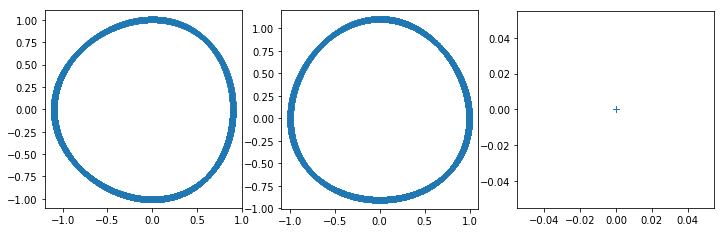

In [11]:
# orbits
plot_traj(settings, qtraj, ptraj)

In [12]:
# qtraj[:,dd,nn,0] # all zeros since because of the initial conditions, in the xy plane only

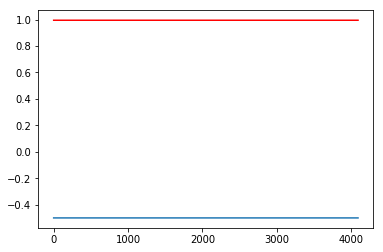

In [12]:
# conserved quantities: angular momentum and energy
J3 = np.multiply(qtraj[:,0,0,0,0], ptraj[:,0,1,0,0]) - np.multiply(qtraj[:,0,1,0,0], ptraj[:,0,0,0,0])
tmp = tf.reshape(traj, [-1,settings['d'],settings['num_particles'],2])
E = sess.run( settings['hamiltonian']( tmp ) )
num_init_cond = qtraj.shape[1]
E = np.reshape(E, [-1,num_init_cond])
ts = np.arange(0.,10.,.01)
plt.plot(J3,'r')
for i in range(num_init_cond):
    plt.plot(E[:,i])

## Define the model and loss

Define the model as sequence of a symplectic transformation T 

In [12]:
# No oscillator flow, map directly to phat,qhat cartesian coords of action-angle
stack = []
for i in range(settings['num_stacks_bijectors']):
    stack.extend([#ZeroCenter(),
                  LinearSymplectic(householder_random_init=False),
#                  SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.tanh))])
                  SymplecticAdditiveCoupling(shift_model=IrrotationalMLP())])
T = Chain(stack)

The loss imposes that the trajectories in the transformed coordinates $\hat{q},\hat{p}$ are on circles of radius given by the actions. We choose the following one which makes couples of points have the same radius:
$$
\ell = \sum_d \sum_n \sum_{i=0}^{N-1} 
\left[\hat{q}(i,d,n)^2+\hat{p}(i,d,n)^2 - (\hat{q}(i-1,d,n)^2+\hat{p}(i-1,d,n)^2)\right]^2
$$

In general, we have a batch of trajectories and we want to impose that transformed coordinates for each batch are on the circle.

In [13]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

# traj is (num_time_samples,batch,d,n,2)
dataset = tf.data.Dataset.from_tensor_slices(traj.astype(NP_DTYPE))
# repeat the dataset indefinetely
dataset = dataset.repeat()
# Shuffle data every epoch time (0th) dimension
dataset = dataset.shuffle(settings['num_time_samples'])
# Specify the minibatch size
dataset = dataset.batch(settings['minibatch_size'])
data_iterator = dataset.make_one_shot_iterator()
x = data_iterator.get_next()

#loss = make_loss(settings, T, x)
with tf.name_scope("canonical_transformation"):
    z = pull_back_traj(settings, T, x)
    loss = make_circle_loss(z) 

train_op = make_train_op(settings, loss, step)

## Train

In [14]:
sess.run(tf.global_variables_initializer())

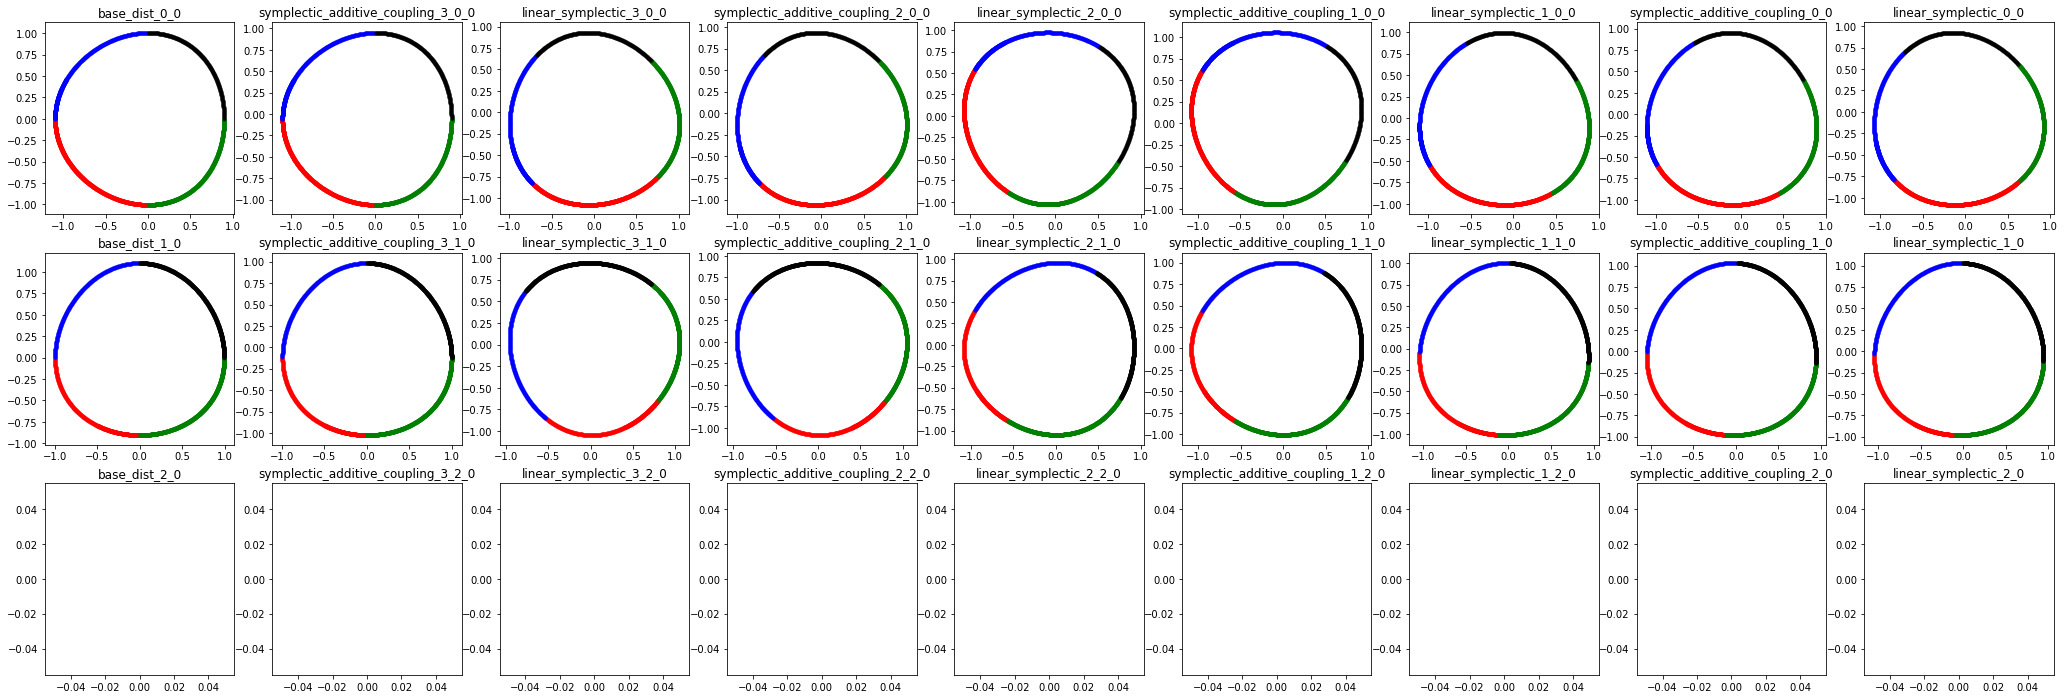

In [15]:
traj_to_show = tf.constant(traj[:,0,:,:,:], dtype=DTYPE)
visualize_chain_bijector(T, traj_to_show, sess=sess, inverse=True)

In [18]:
losses = []
# Coordinates to monitor
dd = 0; nn = 0
loss_np = 1 # Init
loss_converged = 1e-10

Loss at 52000 is 2.1500003999364026e-09


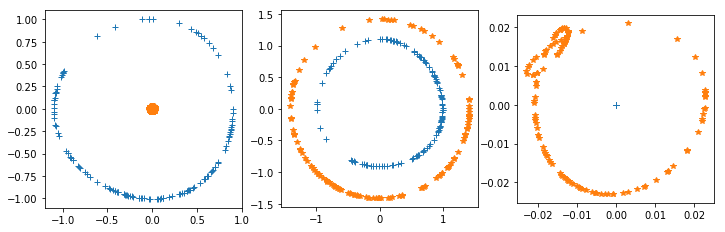

KeyboardInterrupt: 

In [19]:
while loss_np > loss_converged:
    _, it, loss_np = sess.run([train_op, step, loss])
    if it % 1000 == 0:        
        display.clear_output(wait=True)
        print("Loss at {} is {}".format(it, loss_np))
        
        qtraj_mini,ptraj_mini = sess.run(extract_q_p(x))
        qhat_traj_mini,phat_traj_mini = sess.run(extract_q_p(z))

        plot_traj(settings, qtraj_mini, ptraj_mini, qhat_traj_mini, phat_traj_mini)
        #plt.savefig('../results/kepler/image_at_it_{:04d}.png'.format(it))
        plt.show()   
    losses.append(loss_np)

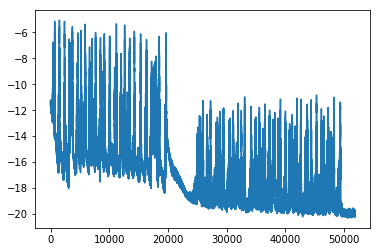

In [20]:
plt.plot(np.log(losses[:]))

In [19]:
# n = 0
# plt.plot(qtraj[:,n,0,0], ptraj[:,n,0,0], '-')
# plt.plot(qhat_traj[:,n,0,0], phat_traj[:,n,0,0], '*')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig('../results/kepler_t2c.png')

In [20]:
# TODO: remove

# with tf.name_scope("canonical_transformation_train_full"):
#     z = pull_back_traj(settings, T, x)
#     loss = make_circle_loss(z) 
# qhat_traj_full,phat_traj_full = sess.run(extract_q_p(z))
# plot_traj(settings, qtraj, ptraj, qhat_traj_full, phat_traj_full)

# ########################################
# # TODO: need to do for each trajectory
# ########################################

# print("Full train error: ", sess.run(loss))

In [20]:
# !pip install -q imageio
# import glob
# import imageio
# path='../results/kepler/'
# with imageio.get_writer(path+'kepler.gif', mode='I') as writer:
#     filenames = glob.glob(path+'image*.png')
#     filenames = sorted(filenames)
#     last = -1
#     for i,filename in enumerate(filenames):
#         frame = 2*(i**0.5)
#         if round(frame) > round(last):
#             last = frame
#         else:
#             continue
#         image = imageio.imread(filename)
#         writer.append_data(image)
#     image = imageio.imread(filename)
#     writer.append_data(image)
    
# # A hack to display the GIF inside this notebook
# os.rename(path+'kepler.gif', 'kepler.gif.png')

In [15]:
#display.Image(filename="kepler.gif.png")

## Test

Check ability to map unseen trajectories to circles

In [21]:
# Set the ZeroCenter bijectors to prediction mode:
for i, bijector in enumerate(T.bijectors):    
    if hasattr(bijector, 'is_training'):
        T.bijectors[i].is_training = False

In [23]:
eccentricity = np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9])
x0_test = make_initial_x_kepler(eccentricity)
q0_test,p0_test = extract_q_p(x0_test)
print("q0 = ", np.reshape(q0_test,[-1]))
print("p0 = ", np.reshape(p0_test,[-1]))
print("E  = ", sess.run( settings['hamiltonian'](x0_test) ))

q0 =  [0.9 0.  0.  0.8 0.  0.  0.7 0.  0.  0.6 0.  0.  0.5 0.  0.  0.4 0.  0.
 0.3 0.  0.  0.2 0.  0.  0.1 0.  0. ]
p0 =  [0.         1.1055416  0.         0.         1.22474487 0.
 0.         1.36277029 0.         0.         1.52752523 0.
 0.         1.73205081 0.         0.         2.         0.
 0.         2.38047614 0.         0.         3.         0.
 0.         4.35889894 0.        ]
E  =  [-0.49999314 -0.49999023 -0.49998542 -0.49997685 -0.49996    -0.49992188
 -0.49981483 -0.49937512 -0.49500375]


In [24]:
traj_test = sess.run( integrator(x0_test, return_full_state=True) )
# traj has shape (num_time_samples,batch,d,n,2). Reinterpret batch and num_time_samples as batch
print(traj_test.shape)
qtraj_test, ptraj_test = extract_q_p( traj_test )

(4096, 9, 3, 1, 2)


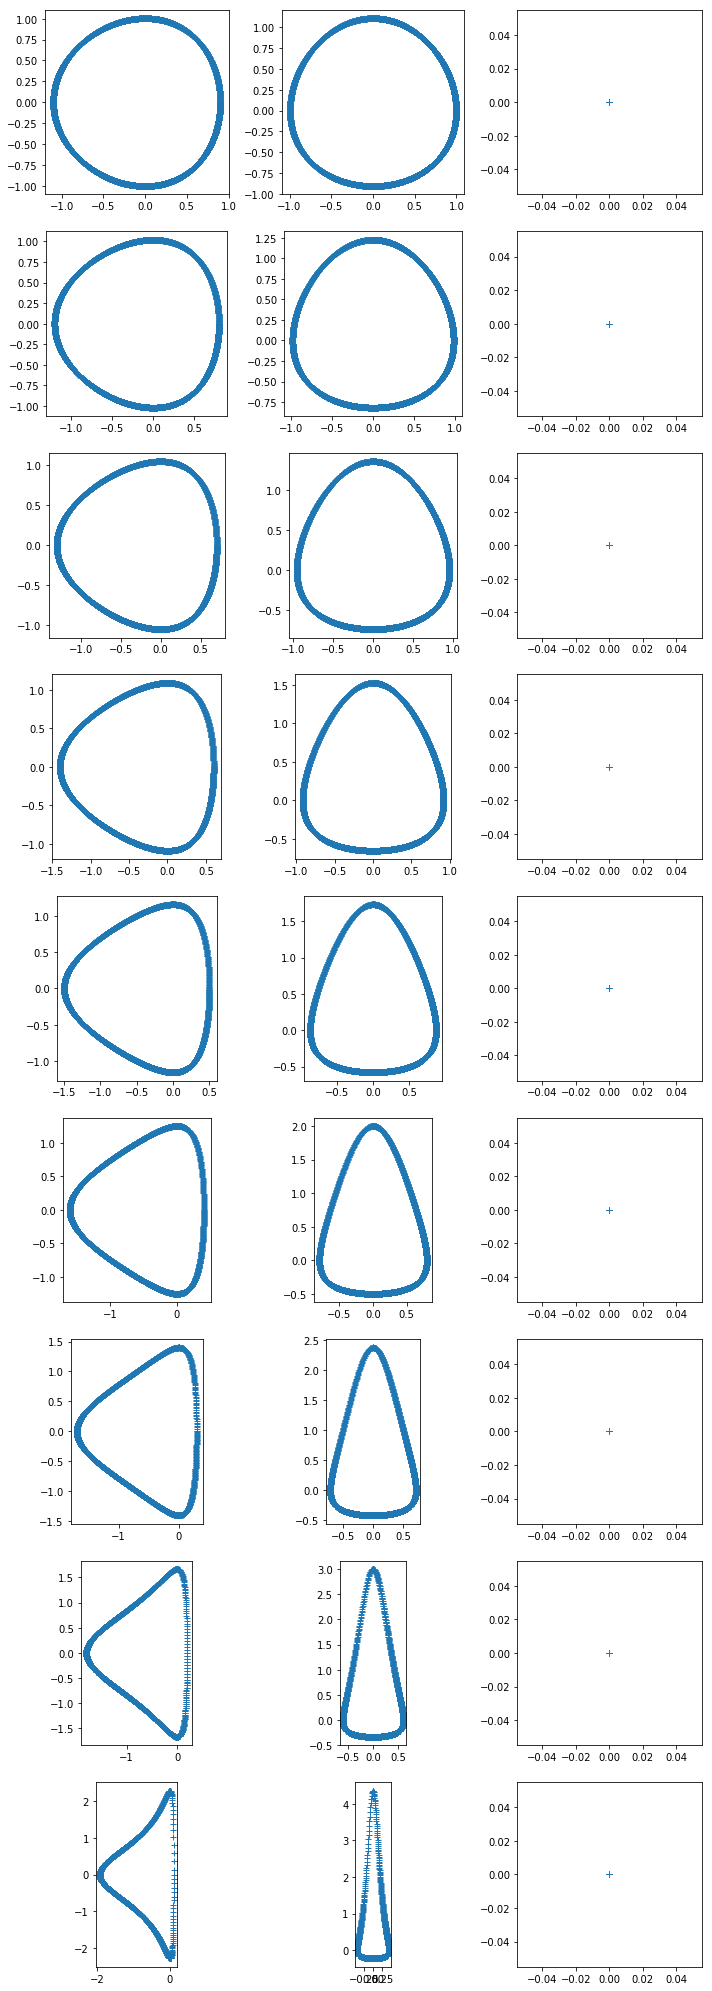

In [25]:
# orbits
plot_traj(settings, qtraj_test, ptraj_test)

In [30]:
from importlib import reload
import utils
reload(utils)
from utils import pull_back_traj

In [32]:
num_init_cond = traj_test.shape[1]
for b in range(num_init_cond):
    tmp = tf.constant(traj_test[:,b,:,:,:], dtype=DTYPE)
    tmp = tf.expand_dims(tmp, axis=1)
    z_test = pull_back_traj(settings, T, tmp)
    loss_test = make_circle_loss(z_test) 
    qhat_traj_test,phat_traj_test = sess.run(extract_q_p(z_test))
    plot_traj(settings, qtraj_test, ptraj_test, qhat_traj_test, phat_traj_test)
    print("Test error: ", sess.run(loss_test))

TypeError: Expected float32, got list containing Tensors of type '_Message' instead.

In [ ]:
traj_to_show = tf.constant(traj_test[:,0,:,:,:], dtype=DTYPE)
visualize_chain_bijector(T, traj_to_show, sess=sess, inverse=True)

Generate trajectories from circles

In [ ]:
settings_test = {
    'base_dist', "action_dirac_angle",    
}

# Choose a batch of actions: needs to be divisor of dataset_size or minibatch_size if infinite dataset
r = np.random.RandomState(seed=0)
num_samples_actions = 1 # number of distinct actions (Liouville torii)
sh = (num_samples_actions, settings['d'], settings['num_particles'], 1)
settings_test['value_actions'] = r.rand(*sh).astype(NP_DTYPE)
print(settings_test['value_actions'])

# circles by mapping to symplectic radial to cartesian coords
circles = OscillatorFlow()( make_data(settings_test, sess) )

In [ ]:
visualize_chain_bijector(T, circles, sess=sess, inverse=False)